In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def display_custom(df):
    # visualize using tabulate for ipython noteboooks
    from IPython.display import display

    # Assuming df is your DataFrame
    with pd.option_context("display.max_rows", None, "display.max_columns", None):
        display(
            df
        )



In [67]:
# Load your dataset
data = pd.read_csv('/Users/antreasantoniou/Work/forge/GATE/notebooks/gate-nn-evolve-0.csv')

data["Name"] = data["Name"].str.replace("gate-evolve-nn-k=", "")
# set name to int and then sort
data["Name"] = data["Name"].astype(int)
data = data.sort_values(by="Name")
display_custom(data)

,Name,mean_score,max_score,min_score,std_score
0,1,1.058165,2.532485,0.615151,0.359992
1,2,0.509159,0.542741,0.440843,0.027338
2,3,0.389367,0.411305,0.350041,0.018272
3,4,0.357962,0.368967,0.338223,0.008213
4,5,0.356425,0.367420,0.338151,0.008299
6,6,0.348367,0.357971,0.325150,0.007828
5,7,0.350680,0.357866,0.332963,0.006713
7,8,0.347287,0.354208,0.333988,0.005556
8,9,0.345444,0.351014,0.325182,0.004335
9,10,0.339617,0.346127,0.315498,0.006003


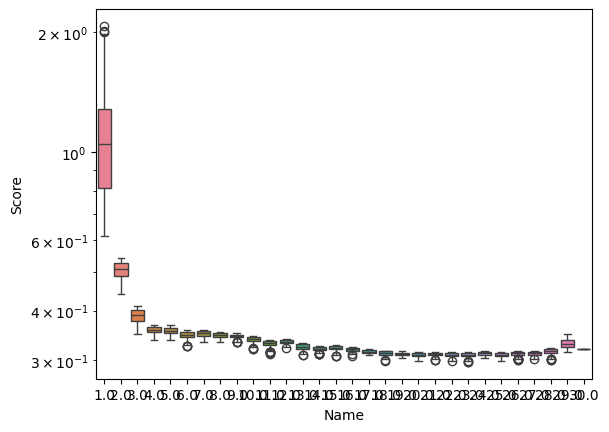

In [68]:
# Initialize a DataFrame to store the simulated data
sim_data = pd.DataFrame()

# For each row in the data, simulate a dataset and add it to sim_data
for idx, row in data.iterrows():
    # Use the normal distribution to simulate data
    if int(row["Name"]) > 0:
        simulated = np.random.normal(loc=row['mean_score'], scale=row['std_score'], size=1000)
        # Clip the simulated data at the min and max values
        simulated = np.clip(simulated, row['min_score'], row['max_score'])
        # Add the simulated data to the DataFrame
        sim_data[str(row['Name'])] = pd.Series(simulated)

# Plot a boxplot of the simulated data
# plt.figure(figsize=(10,6))
sns.boxplot(data=sim_data)
plt.xlabel('Name')
plt.ylabel('Score')
plt.yscale('log')
plt.show()


In [69]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
# Create a Box trace for each row in the data
# Create a Box trace for each 'Name' in the data
# Initialize a DataFrame to store the simulated data
# Create a Box trace for each row in the data
# Create a Box trace for each 'Name' in the data


# Create traces for data points 1 and 2
traces_1_2 = []
for idx, row in data.iterrows():
    if int(row['Name']) <= 2:
        traces_1_2.append(go.Box(
            y=[row['min_score'], row['mean_score'] - row['std_score'], row['mean_score'], row['mean_score'] + row['std_score'], row['max_score']],
            name=int(row['Name']),
            boxpoints=False,
            line_width=2,
        ))

# Create traces for data points 3 and above
traces_3_plus = []
for idx, row in data.iterrows():
    if int(row['Name']) > 2 and int(row['Name']) <= 28:
        traces_3_plus.append(go.Box(
            y=[row['min_score'], row['mean_score'] - row['std_score'], row['mean_score'], row['mean_score'] + row['std_score'], row['max_score']],
            name=int(row['Name']),
            boxpoints=False,
            line_width=2,
        ))

# Create a figure with two subplots
fig = make_subplots(rows=1, cols=2, subplot_titles=("k=1, 2", "k>=3"))

# Add traces to the subplots
for trace in traces_1_2:
    fig.add_trace(trace, row=1, col=1)

for trace in traces_3_plus:
    fig.add_trace(trace, row=1, col=2)

# Update the layout
fig.update_layout(
    # title_text="Mean Squared Error for Different Number of Datasets (k)",
    
    yaxis_title='MSE',
    # xaxis_title='k (num datasets)',
    width=1200,  # Width of the figure in pixels
    # height=400,  # Height of the figure in pixels
    autosize=False,
    showlegend=False,
    margin=dict(l=0, r=10, t=50, b=50),
    font=dict(
        family="Arial",  # Font family
        size=20,  # Font size
    ),
    # yaxis=dict(
    #     title_font=dict(
    #         size=14,  # Y-axis title font size
    #     ),
    #     tickfont=dict(
    #         size=12,  # Y-axis tick font size
    #     ),
    # ),
    # xaxis=dict(
    #     tickfont=dict(
    #         size=12,  # X-axis tick font size
    #     ),
    # ),
)
# Save the figure as a PDF
fig.write_image("boxplots.pdf")
fig.show()




In [70]:
import dis
import pandas as pd
import plotly.express as px

# Load the data from the CSV file
data = pd.read_csv('k=14-nn-evolve-1.csv')
# transpose
data = data.T
# Set the first row as the column names and remove it
data.columns = data.iloc[0]
data = data[1:]
# remove term gate-evolve-nn-k=14-loo- and .mean from Name
data["Name"] = data.index.str.replace("gate-evolve-nn-k=14-loo-", "").str.replace("newyorkercaptioncontest", "nyc")
# split name into two columns using . as separator
data[['Name', 'Statistic']] = data["Name"].str.split(".", expand=True)
# display_custom(data)
# rename second column to Score
data = data.rename(columns={data.columns[0]: "Value"})
# sort by score
data = data.sort_values(by="Value", ascending=False)
# remove rows with nan values
data = data.dropna()
display_custom(data)



Name,Value,Name,Statistic
gate-evolve-nn-k=14-loo-pokemonblipcaptions.max,0.804118,pokemonblipcaptions,max
gate-evolve-nn-k=14-loo-ham10k.max,0.78507,ham10k,max
gate-evolve-nn-k=14-loo-fungi.max,0.776644,fungi,max
gate-evolve-nn-k=14-loo-coco-10k.max,0.773991,coco-10k,max
gate-evolve-nn-k=14-loo-aircraft.max,0.772783,aircraft,max
gate-evolve-nn-k=14-loo-chexpert.max,0.751507,chexpert,max
gate-evolve-nn-k=14-loo-cubirds.max,0.751103,cubirds,max
gate-evolve-nn-k=14-loo-clevr.max,0.687444,clevr,max
gate-evolve-nn-k=14-loo-nyu.max,0.684614,nyu,max
gate-evolve-nn-k=14-loo-imagenet1k.max,0.671437,imagenet1k,max


In [71]:
stats_data = {
    'Name': [],
    'min_score': [],
    'mean_score': [],
    'max_score': [],
    'std_score': []
}

for name, group in data.groupby('Name'):
    min_row = group[group['Statistic'] == 'min']
    mean_row = group[group['Statistic'] == 'mean']
    max_row = group[group['Statistic'] == 'max']
    std_row = group[group['Statistic'] == 'std']

    stats_data['Name'].append(name)
    stats_data['min_score'].append(min_row['Value'].values[0] if not min_row.empty else None)
    stats_data['mean_score'].append(mean_row['Value'].values[0] if not mean_row.empty else None)
    stats_data['max_score'].append(max_row['Value'].values[0] if not max_row.empty else None)
    stats_data['std_score'].append(std_row['Value'].values[0] if not std_row.empty else None)

stats_df = pd.DataFrame(stats_data)

# Now create the box plots
traces = []
for idx, row in stats_df.iterrows():
    # Check if we have all necessary stats to plot
    if pd.notnull(row['min_score']) and pd.notnull(row['mean_score']) and pd.notnull(row['max_score']) and pd.notnull(row['std_score']):
        traces.append(go.Box(
            y=[row['min_score'], row['mean_score'] - row['std_score'], row['mean_score'], row['mean_score'] + row['std_score'], row['max_score']],
            name=row['Name'],
            boxpoints=False,
            line_width=2,
        ))

# Create the figure and add traces
fig = go.Figure(traces)
fig.show()

In [72]:
# Calculate the difference from 'full' variant
data = stats_df.copy()
# sort by mean_score
data = data.sort_values(by="mean_score", ascending=False)
display_custom(data)
full_score = data[data['Name'] == 'full']['mean_score'].values[0]
data['Score Difference'] = data['mean_score'] - full_score
# rename pokemonblipcaptions to pokemonblip
data["Name"] = data["Name"].str.replace("pokemonblipcaptions", "pokemonblip")
font_size = 18
# Create a line chart with markers using Plotly
fig = px.bar(data, x='Name', y='Score Difference', labels={'Name': 'Dataset Name', 'Score Difference':'Score Difference (lower is better)'})
fig.update_layout(
    # height=300,
    width=500,
    showlegend=False,
    font=dict(size=font_size),  # Global font size
    yaxis=dict(
        title_font=dict(size=font_size),  # Y-axis title font size
        tickfont=dict(size=font_size),  # Y-axis tick font size
    ),
    xaxis=dict(
        title_font=dict(size=font_size),  # X-axis title font size (if any)
        tickfont=dict(size=font_size),  # X-axis tick font size
    ),
    # margin=dict(l=20, r=20, t=20, b=20),  # margins
    
)

# Save the figure as a PDF file
fig.write_image("figure.pdf")
# Show the figure
fig.show()

,Name,min_score,mean_score,max_score,std_score
10,nyu,0.180734,0.437050,0.684614,0.135740
4,coco-10k,0.173421,0.432062,0.773991,0.148052
3,clevr,0.160353,0.416699,0.687444,0.127256
14,winoground,0.155647,0.411191,0.619738,0.132889
0,aircraft,0.171748,0.408978,0.772783,0.146177
1,chexpert,0.172072,0.404609,0.751507,0.141545
12,ucf,0.163736,0.401720,0.619220,0.115760
9,imagenet1k,0.163091,0.401064,0.671437,0.129917
11,pokemonblipcaptions,0.165746,0.389157,0.804118,0.131605
8,ham10k,0.179612,0.375283,0.785070,0.137777


In [73]:
sub_gate_columns = data["Name"]

sub_gate_columns = sub_gate_columns[1:]
sub_gate_columns = ["newyorkercaptioncontest" if col == "nycc" else col for col in sub_gate_columns]
print(sub_gate_columns)


[
    'coco-10k',
    'clevr',
    'winoground',
    'aircraft',
    'chexpert',
    'ucf',
    'imagenet1k',
    'pokemonblip',
    'ham10k',
    'cifar100',
    'fungi',
    'vgg',
    'cubirds',
    'full'
]

In [74]:
import pathlib
import pandas as pd
import yaml
from rich import print

def load_data_as_df(filepath):
    df = pd.read_csv(filepath)
    task_dataset_dict = yaml.safe_load(open("task_mapping2.yaml"))

    
    # replace NA with 5
    df = df.fillna(5)
    df = df.rename(columns={"Unnamed: 0": "model_name"})
    # if a columne has testing/ensemble_3/ in it then rename it to replace testing/ensemble_3/ with ''
    df.columns = df.columns.str.replace("testing/ensemble_3/", "")
    # if any columns with the keyword "loss" are larger than 10, set them to the value of 10
    loss_columns = df.columns[df.columns.str.contains('loss', case=False)]
    for col in loss_columns:
        df[col] = df[col].apply(lambda x: 10 if x > 10 else x)
        
    
    
    
    columns = df.columns.tolist()[1:]
    model_names = df.columns.tolist()[0]
    # remove all datapoints with less than 50% on imagenet1k.1

    # Replace NA with 5
    df = df.fillna(1)
    # model_names = df[model_names][1:]

    # Convert all columns (except the first) to numeric
    for col in df.columns[1:]:
        df[col] = pd.to_numeric(df[col], errors="coerce")
    
    # All columns that have mae in the name should be divided by 5 and then the result should be subtracted from 1 and multiplied by 100
    mae_columns = df.columns[df.columns.str.contains('dice', case=False)]
    for col in mae_columns:
        df[col] = (1-df[col]) * 100
    
    # columns with mae or loss in their name (except those with dice loss) should be divided by 4 and then the result should be subtracted from 1 and multiplied by 100
    
    selected_columns = df.columns[df.columns.str.contains('mae|loss|bs', case=False) & ~df.columns.str.contains('dice', case=False)]
    for col in selected_columns:
        df[col] = (1-df[col] / 10.) * 100
        
    for col in df.columns[1:]:
        if df[col].max() < 1:  # Check if the column is in a fractional format
            df[col] = df[col] * 100  # Convert to percentage format
    
    # for col in columns:
    #     df[col] = (df[col] - df[col].min())
    
    # gaussian normalization
    # for col in columns:
    #     df[col] = (df[col] - df[col].mean()) / df[col].std()
    
    # Add a new column for each task, where the value is the mean of the columns that are in the task
    columns = df.columns.tolist()
    columns = sorted(columns)
    dataset_to_task_dict = {item: k for k, v in task_dataset_dict.items() for item in v}
    
    for task, datasets in task_dataset_dict.items():
        metrics_matching_datasets = [col for col in columns if any([dataset in col for dataset in datasets])]
        df[task] = df[metrics_matching_datasets].mean(axis=1)
    
    return df

source_csv_filepath = (
    "s01042024_df.csv"
)
source_csv_filepath = pathlib.Path(source_csv_filepath)

df = load_data_as_df(source_csv_filepath)
display_custom(df)


/var/folders/gh/_5t3nhn94t12m7rh483b8b7r0000gn/T/ipykernel_97770/603839764.py:65: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/var/folders/gh/_5t3nhn94t12m7rh483b8b7r0000gn/T/ipykernel_97770/603839764.py:65: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/var/folders/gh/_5t3nhn94t12m7rh483b8b7r0000gn/T/ipykernel_97770/603839764.py:65: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.co

,model_name,acdc.mIoU,acdc.overall_accuracy,acdc.mean_accuracy,acdc.dice_loss-epoch-mean,ade20k.mean_accuracy,ade20k.mIoU,ade20k.focal_loss-epoch-mean,ade20k.loss-epoch-mean,ade20k.overall_accuracy,ade20k.dice_loss-epoch-mean,ade20k.ce_loss-epoch-mean,cityscapes.focal_loss-epoch-mean,cityscapes.ce_loss-epoch-mean,cityscapes.dice_loss-epoch-mean,cityscapes.loss-epoch-mean,coco-164k.focal_loss-epoch-mean,coco-164k.mean_accuracy,coco-164k.mIoU,coco-164k.ce_loss-epoch-mean,coco-164k.overall_accuracy,coco-164k.dice_loss-epoch-mean,coco-164k.loss-epoch-mean,nyu.focal_loss-epoch-mean,nyu.loss-epoch-mean,nyu.ce_loss-epoch-mean,nyu.dice_loss-epoch-mean,nyu.mean_accuracy,nyu.mIoU,nyu.overall_accuracy,pascal.loss-epoch-mean,pascal.overall_accuracy,pascal.focal_loss-epoch-mean,pascal.mean_accuracy,pascal.dice_loss-epoch-mean,pascal.ce_loss-epoch-mean,pascal.mIoU,aircraft.accuracy_top_1-epoch-mean,aircraft.loss-epoch-mean,chexpert.loss,chexpert.2-aps,chexpert.bs-macro,chexpert.0-auc,chexpert.3-bs,chexpert.0-bs,chexpert.1-bs,chexpert.1-aps,chexpert.0-aps,chexpert.3-auc,chexpert.4-auc,chexpert.1-auc,chexpert.aps-macro,chexpert.auc-macro,chexpert.2-auc,chexpert.4-bs,chexpert.3-aps,chexpert.4-aps,chexpert.2-bs,cifar100.loss-epoch-mean,cifar100.accuracy_top_1-epoch-mean,cifar100.accuracy_top_5-epoch-mean,clevr.loss_material-epoch-mean,clevr.accuracy_top_1_shape-epoch-mean,clevr.loss_yes_no-epoch-mean,clevr.accuracy_top_1_material-epoch-mean,clevr.accuracy_top_1-epoch-mean,clevr.accuracy_top_1_count-epoch-mean,clevr.accuracy_top_1_size-epoch-mean,clevr.loss-epoch-mean,clevr.loss_shape-epoch-mean,clevr.accuracy_top_1_colour-epoch-mean,clevr.accuracy_top_1_yes_no-epoch-mean,clevr.loss_size-epoch-mean,clevr.loss_count-epoch-mean,clevr.loss_colour-epoch-mean,clevr-math.loss-epoch-mean,clevr-math.accuracy_top_5-epoch-mean,clevr-math.accuracy_top_1-epoch-mean,cubirds.accuracy_top_1-epoch-mean,cubirds.loss-epoch-mean,diabetic.loss,diabetic.0-bs,diabetic.3-auc,diabetic.4-aps,diabetic.0-auc,diabetic.auc-macro,diabetic.3-bs,diabetic.4-bs,diabetic.2-bs,diabetic.1-auc,diabetic.3-aps,diabetic.bs-macro,diabetic.2-auc,diabetic.aps-macro,diabetic.1-bs,diabetic.1-aps,diabetic.0-aps,diabetic.2-aps,diabetic.4-auc,dtextures.accuracy_top_1-epoch-mean,dtextures.loss-epoch-mean,flickr30k.image_to_text_accuracy-epoch-mean,flickr30k.loss-epoch-mean,flickr30k.image_to_text_loss-epoch-mean,flickr30k.image_to_text_accuracy_top_5-epoch-mean,flickr30k.text_to_image_accuracy_top_5-epoch-mean,flickr30k.text_to_image_accuracy-epoch-mean,flickr30k.text_to_image_loss-epoch-mean,food101.accuracy_top_1-epoch-mean,food101.accuracy_top_5-epoch-mean,food101.loss-epoch-mean,fungi.loss-epoch-mean,fungi.accuracy_top_1-epoch-mean,ham10k.2-auc,ham10k.5-auc,ham10k.aps-macro,ham10k.6-bs,ham10k.auc-macro,ham10k.0-bs,ham10k.4-aps,ham10k.0-auc,ham10k.1-auc,ham10k.4-bs,ham10k.0-aps,ham10k.5-aps,ham10k.6-aps,ham10k.3-aps,ham10k.2-aps,ham10k.3-auc,ham10k.6-auc,ham10k.1-aps,ham10k.loss,ham10k.2-bs,ham10k.bs-macro,ham10k.5-bs,ham10k.1-bs,ham10k.3-bs,ham10k.4-auc,happy.accuracy_top_5-epoch-mean,happy.loss_individual-epoch-mean,happy.accuracy_top_1-epoch-mean,happy.loss_species-epoch-mean,happy.accuracy_top_1_individual-epoch-mean,happy.accuracy_top_1_species-epoch-mean,happy.loss-epoch-mean,happy.accuracy_top_5_individual-epoch-mean,happy.accuracy_top_5_species-epoch-mean,hmdb51.accuracy_top_5-epoch-mean,hmdb51.loss-epoch-mean,hmdb51.accuracy_top_1-epoch-mean,imagenet1k.accuracy_top_1-epoch-mean,imagenet1k.accuracy_top_5-epoch-mean,imagenet1k.loss-epoch-mean,iwildcam.mse_loss-epoch-mean,iwildcam.mae_loss-epoch-mean,iwildcam.loss-epoch-mean,kinetics.accuracy_top_1-epoch-mean,kinetics.accuracy_top_5-epoch-mean,kinetics.loss-epoch-mean,mini.accuracy_top_1-epoch-mean,mini.loss-epoch-mean,newyorkercaptioncontest.image_to_text_accuracy_top_5-epoch-mean,newyorkercaptioncontest.text_to_image_accuracy-epoch-mean,newyorkercaptioncontest.loss-epoch-mean,newyorkercaptioncontest.image_to_text_loss-epoch-mean,newy

In [75]:
def move_column(df, column_name, position):
    """
    Move a specific column to a specified position in a DataFrame.

    Parameters:
    df (pandas.DataFrame): The DataFrame to modify.
    column_name (str): The name of the column to move.
    position (int): The position to move the column to.

    Returns:
    pandas.DataFrame: The modified DataFrame.
    """
    # Ensure the position is within the valid range
    if position < 0 or position > len(df.columns):
        raise ValueError(f"Position must be between 0 and {len(df.columns)}")

    # Get a list of the column names
    cols = df.columns.tolist()

    # Check if the column name is in the list
    if column_name in cols:
        # Remove the column from its current position
        cols.remove(column_name)

        # Insert the column at the specified position
        cols.insert(position, column_name)

        # Reorder the DataFrame
        df = df[cols]

    return df

In [76]:
import yaml

task_to_dataset_metrics = yaml.safe_load(open("task_mapping2.yaml"))
idx = 1
for task_name, dataset_metrics in task_to_dataset_metrics.items():
    for metric in dataset_metrics:
        df = move_column(df, metric, idx)
        idx += 1
print(task_to_dataset_metrics)

{
    'Image Classification': ['cifar100', 'food101', 'happy', 'imagenet1k', 'places365'],
    'Few Shot Image Classification': ['aircraft', 'cubirds', 'dtextures', 'fungi', 'mini', 'omniglot', 'vgg'],
    'Image Segmentation': ['ade20k', 'cityscapes', 'coco', 'nyu', 'pascal'],
    'Image Relational Reasoning': ['clevr', 'clevr-math'],
    'Medical Classification': ['chexpert', 'diabetic', 'ham10k'],
    'Medical Segmentation': ['acdc'],
    'Image to Text Zero Shot Learning': [
        'flickr30k',
        'newyorkercaptioncontest',
        'pokemonblipcaptions',
        'winoground'
    ],
    'Video Classification': ['hmdb51', 'kinetics', 'ucf'],
    'Video Regression': ['iwildcam']
}

In [77]:
modality_shift = ["bart", "bert", "whisper", "mpnet"]
pretraining_shift = ["ar-vit-b16", "clip-b16", "dino-b16", "deit3-b16", "flex-b-1200ep", "laion-b16", "siglip-p16"]
architecture_shift = ["ar-vit-b16", "convnextv2-base", "effv2-rw-s", "rnx50-32x4a1", "svit-b16", "effformer-s0"]
print(df["model_name"])

0            clip-b16
1          ar-vit-b16
2           deit3-b16
3            dino-b16
4          effv2-rw-s
5           laion-b16
6        rnx50-32x4a1
7          siglip-p16
8            svit-b16
9       flex-b-1200ep
10               bart
11               bert
12    convnextv2-base
13       effformer-s0
14              mpnet
15            whisper
Name: model_name, dtype: object

In [78]:
import numpy as np

def generate_palette(palette, target_length):
    if len(palette) >= target_length:
        return palette[:target_length]
    else:
        # Interpolate colors in the palette
        colors = np.array([px.colors.hex_to_rgb(color) for color in palette])
        new_colors = np.array([
            np.interp(np.linspace(0, len(colors) - 1, target_length), np.arange(len(colors)), colors[:, i])
            for i in range(3)
        ]).T.astype(int)
        return [f'rgb({r},{g},{b})' for r, g, b in new_colors]

In [79]:
import plotly.express as px
import plotly.graph_objects as go
# Preprocess data for polar plot
color_palette = px.colors.sequential.Magma_r  # Original palette
target_length = len(architecture_shift)
color_palette = generate_palette(color_palette, target_length)

categories = df.columns[-8:]  # Exclude the first column (Model.Metric)
values = df.iloc[:, -8:].values  # Exclude the first column

categories = [category.replace("Classification", "Class").replace("Zero Shot", "ZS").replace("Image", "Img").replace("Regression", "Reg").replace("Few Shot", "FS").replace("Segmentation", "Seg") for category in categories]  # Shorten the category names
# dataframe that includes only Model.Metrics matching entries in pretraining_shift
new_df = df[df['model_name'].isin(architecture_shift)]
columns = new_df.columns
# gaussian normalization
# for col in columns[1:]:
#     new_df[col] = (new_df[col] - new_df[col].mean()) / (new_df[col].std())
values = new_df.iloc[:, -8:].values  # Exclude the first column
new_df = new_df.reset_index(drop=True)
# Create polar plot for each model
fig = go.Figure()
for i, model in enumerate(architecture_shift):
    id = new_df[new_df['model_name'] == model].index[0]
    color_index = i % len(color_palette)  # Ensure the index is within the range of the color palette
    fig.add_trace(go.Scatterpolar(
        r=values[i],
        theta=categories,
        name=model,
        mode='lines',
        line=dict(color=color_palette[color_index])  
        
    ))
    fig.add_trace(go.Scatterpolar(
        r=[values[i][0], values[i][-1]],
        theta=[categories[0], categories[-1]],
        name=model,
        mode='lines',
        showlegend=False,
        line=dict(color=color_palette[color_index]) 
        
    ))
    
    

# Update layout
fig.update_layout(
    height=400,
    width=400,
    autosize=True,
    margin=dict(
            l=50,
            r=50,
            b=50,
            t=100,
            pad=4
        ),
    font=dict(
        size=8
    ),
)

# make legend smaller and move it to the top center
fig.update_layout(
    legend=dict(
        orientation="h",
        yanchor="top",
        y=1.4,
        xanchor="center",
        x=0.5
    )
)

fig.show()
fig.write_image("architecture_polar_plot.pdf")
fig.write_image("architecture_polar_plot.png")

In [80]:
import plotly.express as px
# Preprocess data for polar plot
color_palette = px.colors.sequential.Magma_r  # Original palette
target_length = len(pretraining_shift)
color_palette = generate_palette(color_palette, target_length)

categories = df.columns[-8:]  # Exclude the first column (Model.Metric)
values = df.iloc[:, -8:].values  # Exclude the first column

categories = [category.replace("Classification", "Class").replace("Zero Shot", "ZS").replace("Image", "Img").replace("Regression", "Reg").replace("Few Shot", "FS").replace("Segmentation", "Seg") for category in categories]  # Shorten the category names
# dataframe that includes only Model.Metrics matching entries in pretraining_shift
new_df = df[df['model_name'].isin(pretraining_shift)]
columns = new_df.columns
# gaussian normalization
# for col in columns[1:]:
#     new_df[col] = (new_df[col] - new_df[col].mean()) / new_df[col].std()
values = new_df.iloc[:, -8:].values  # Exclude the first column
new_df = new_df.reset_index(drop=True)
# Create polar plot for each model
fig = go.Figure()
for i, model in enumerate(pretraining_shift):
    id = new_df[new_df['model_name'] == model].index[0]
    color_index = i % len(color_palette)  # Ensure the index is within the range of the color palette
    fig.add_trace(go.Scatterpolar(
        r=values[i],
        theta=categories,
        name=model,
        mode='lines',
        line=dict(color=color_palette[color_index])  
        
    ))
    fig.add_trace(go.Scatterpolar(
        r=[values[i][0], values[i][-1]],
        theta=[categories[0], categories[-1]],
        name=model,
        mode='lines',
        showlegend=False,
        line=dict(color=color_palette[color_index]) 
        
    ))
    
    

# Update layout
fig.update_layout(
    height=400,
    width=400,
    autosize=True,
    margin=dict(
            l=50,
            r=50,
            b=50,
            t=100,
            pad=4
        ),
    font=dict(
        size=8
    ),
)

# make legend smaller and move it to the top center
fig.update_layout(
    legend=dict(
        orientation="h",
        yanchor="top",
        y=1.4,
        xanchor="center",
        x=0.5
    )
)

fig.show()
fig.write_image("pretraining_polar_plot.pdf")
fig.write_image("pretraining_polar_plot.png")

In [81]:
import plotly.express as px
# Preprocess data for polar plot
color_palette = px.colors.sequential.Magma_r  # Original palette
target_length = len(modality_shift)
color_palette = generate_palette(color_palette, target_length)

categories = df.columns[-8:]  # Exclude the first column (Model.Metric)
values = df.iloc[:, -8:].values  # Exclude the first column

categories = [category.replace("Classification", "Class").replace("Zero Shot", "ZS").replace("Image", "Img").replace("Regression", "Reg").replace("Few Shot", "FS").replace("Segmentation", "Seg") for category in categories]  # Shorten the category names
# dataframe that includes only Model.Metrics matching entries in pretraining_shift
new_df = df[df['model_name'].isin(modality_shift)]
columns = new_df.columns
# gaussian normalization
# for col in columns[1:]:
#     new_df[col] = (new_df[col] - new_df[col].mean()) / new_df[col].std()
values = new_df.iloc[:, -8:].values  # Exclude the first column
new_df = new_df.reset_index(drop=True)
# Create polar plot for each model
fig = go.Figure()
for i, model in enumerate(modality_shift):
    id = new_df[new_df['model_name'] == model].index[0]
    color_index = i % len(color_palette)  # Ensure the index is within the range of the color palette
    fig.add_trace(go.Scatterpolar(
        r=values[i],
        theta=categories,
        name=model,
        mode='lines',
        line=dict(color=color_palette[color_index])  
        
    ))
    fig.add_trace(go.Scatterpolar(
        r=[values[i][0], values[i][-1]],
        theta=[categories[0], categories[-1]],
        name=model,
        mode='lines',
        showlegend=False,
        line=dict(color=color_palette[color_index]) 
        
    ))
    
    

# Update layout
fig.update_layout(
    height=400,
    width=400,
    autosize=True,
    margin=dict(
            l=50,
            r=50,
            b=50,
            t=100,
            pad=4
        ),
    font=dict(
        size=8
    ),
)

# make legend smaller and move it to the top center
fig.update_layout(
    legend=dict(
        orientation="h",
        yanchor="top",
        y=1.4,
        xanchor="center",
        x=0.5
    )
)

fig.show()
fig.write_image("modality_polar_plot.pdf")
fig.write_image("modality_polar_plot.png")

In [82]:
column_names = list(df.columns)

print(column_names)

[
    'model_name',
    'acdc.mIoU',
    'acdc.overall_accuracy',
    'acdc.mean_accuracy',
    'acdc.dice_loss-epoch-mean',
    'ade20k.mean_accuracy',
    'ade20k.mIoU',
    'ade20k.focal_loss-epoch-mean',
    'ade20k.loss-epoch-mean',
    'ade20k.overall_accuracy',
    'ade20k.dice_loss-epoch-mean',
    'ade20k.ce_loss-epoch-mean',
    'cityscapes.focal_loss-epoch-mean',
    'cityscapes.ce_loss-epoch-mean',
    'cityscapes.dice_loss-epoch-mean',
    'cityscapes.loss-epoch-mean',
    'coco-164k.focal_loss-epoch-mean',
    'coco-164k.mean_accuracy',
    'coco-164k.mIoU',
    'coco-164k.ce_loss-epoch-mean',
    'coco-164k.overall_accuracy',
    'coco-164k.dice_loss-epoch-mean',
    'coco-164k.loss-epoch-mean',
    'nyu.focal_loss-epoch-mean',
    'nyu.loss-epoch-mean',
    'nyu.ce_loss-epoch-mean',
    'nyu.dice_loss-epoch-mean',
    'nyu.mean_accuracy',
    'nyu.mIoU',
    'nyu.overall_accuracy',
    'pascal.loss-epoch-mean',
    'pascal.overall_accuracy',
    'pascal.focal_loss-epoch-mean',
    'pascal.mean_accuracy',
    'pascal.dice_loss-epoch-mean',
    'pascal.ce_loss-epoch-mean',
    'pascal.mIoU',
    'aircraft.accuracy_top_1-epoch-mean',
    'aircraft.loss-epoch-mean',
    'chexpert.loss',
    'chexpert.2-aps',
    'chexpert.bs-macro',
    'chexpert.0-auc',
    'chexpert.3-bs',
    'chexpert.0-bs',
    'chexpert.1-bs',
    'chexpert.1-aps',
    'chexpert.0-aps',
    'chexpert.3-auc',
    'chexpert.4-auc',
    'chexpert.1-auc',
    'chexpert.aps-macro',
    'chexpert.auc-macro',
    'chexpert.2-auc',
    'chexpert.4-bs',
    'chexpert.3-aps',
    'chexpert.4-aps',
    'chexpert.2-bs',
    'cifar100.loss-epoch-mean',
    'cifar100.accuracy_top_1-epoch-mean',
    'cifar100.accuracy_top_5-epoch-mean',
    'clevr.loss_material-epoch-mean',
    'clevr.accuracy_top_1_shape-epoch-mean',
    'clevr.loss_yes_no-epoch-mean',
    'clevr.accuracy_top_1_material-epoch-mean',
    'clevr.accuracy_top_1-epoch-mean',
    'clevr.accuracy_top_1_count-epoch-mean',
    'clevr.accuracy_top_1_size-epoch-mean',
    'clevr.loss-epoch-mean',
    'clevr.loss_shape-epoch-mean',
    'clevr.accuracy_top_1_colour-epoch-mean',
    'clevr.accuracy_top_1_yes_no-epoch-mean',
    'clevr.loss_size-epoch-mean',
    'clevr.loss_count-epoch-mean',
    'clevr.loss_colour-epoch-mean',
    'clevr-math.loss-epoch-mean',
    'clevr-math.accuracy_top_5-epoch-mean',
    'clevr-math.accuracy_top_1-epoch-mean',
    'cubirds.accuracy_top_1-epoch-mean',
    'cubirds.loss-epoch-mean',
    'diabetic.loss',
    'diabetic.0-bs',
    'diabetic.3-auc',
    'diabetic.4-aps',
    'diabetic.0-auc',
    'diabetic.auc-macro',
    'diabetic.3-bs',
    'diabetic.4-bs',
    'diabetic.2-bs',
    'diabetic.1-auc',
    'diabetic.3-aps',
    'diabetic.bs-macro',
    'diabetic.2-auc',
    'diabetic.aps-macro',
    'diabetic.1-bs',
    'diabetic.1-aps',
    'diabetic.0-aps',
    'diabetic.2-aps',
    'diabetic.4-auc',
    'dtextures.accuracy_top_1-epoch-mean',
    'dtextures.loss-epoch-mean',
    'flickr30k.image_to_text_accuracy-epoch-mean',
    'flickr30k.loss-epoch-mean',
    'flickr30k.image_to_text_loss-epoch-mean',
    'flickr30k.image_to_text_accuracy_top_5-epoch-mean',
    'flickr30k.text_to_image_accuracy_top_5-epoch-mean',
    'flickr30k.text_to_image_accuracy-epoch-mean',
    'flickr30k.text_to_image_loss-epoch-mean',
    'food101.accuracy_top_1-epoch-mean',
    'food101.accuracy_top_5-epoch-mean',
    'food101.loss-epoch-mean',
    'fungi.loss-epoch-mean',
    'fungi.accuracy_top_1-epoch-mean',
    'ham10k.2-auc',
    'ham10k.5-auc',
    'ham10k.aps-macro',
    'ham10k.6-bs',
    'ham10k.auc-macro',
    'ham10k.0-bs',
    'ham10k.4-aps',
    'ham10k.0-auc',
    'ham10k.1-auc',
    'ham10k.4-bs',
    'ham10k.0-aps',
    'ham10k.5-aps',
    'ham10k.6-aps',
    'ham10k.3-aps',
    'ham10k.2-aps',
    'ham10k.3-auc',
    'ham10k.6-auc',
    'ham10k.1-aps',
    'ham10k.loss',
    'ham10k.2-bs',
    'ham10k.bs-macro',
    'ham10k.5-bs',
    'ham10k.1-bs',
    'ham10k.3-bs',
    'ham

In [83]:
import yaml


task_to_dataset = yaml.safe_load(open("task_mapping2.yaml"))
task_to_metric = {}
for key, datasets in task_to_dataset.items():
    task_to_metric[key] = []
    for dataset in datasets:
        for metric in df.columns:
            if dataset in metric:
                task_to_metric[key].append(metric)

task_to_metric = {k: [d for d in v if d in df.columns] for k, v in task_to_metric.items()}
dataset_to_weight = {}
for task_name, task_datasets in task_to_metric.items():
    for dataset in task_datasets:
        dataset_to_weight[dataset] = 1. / len(task_datasets) / len(task_to_metric)
print(task_to_metric)
print(dataset_to_weight)
print(f"Sum of weights: {sum(dataset_to_weight.values())}")

{
    'Image Classification': [
        'cifar100.loss-epoch-mean',
        'cifar100.accuracy_top_1-epoch-mean',
        'cifar100.accuracy_top_5-epoch-mean',
        'food101.accuracy_top_1-epoch-mean',
        'food101.accuracy_top_5-epoch-mean',
        'food101.loss-epoch-mean',
        'happy.accuracy_top_5-epoch-mean',
        'happy.loss_individual-epoch-mean',
        'happy.accuracy_top_1-epoch-mean',
        'happy.loss_species-epoch-mean',
        'happy.accuracy_top_1_individual-epoch-mean',
        'happy.accuracy_top_1_species-epoch-mean',
        'happy.loss-epoch-mean',
        'happy.accuracy_top_5_individual-epoch-mean',
        'happy.accuracy_top_5_species-epoch-mean',
        'imagenet1k.accuracy_top_1-epoch-mean',
        'imagenet1k.accuracy_top_5-epoch-mean',
        'imagenet1k.loss-epoch-mean',
        'places365.accuracy_top_5-epoch-mean',
        'places365.accuracy_top_1-epoch-mean',
        'places365.loss-epoch-mean'
    ],
    'Few Shot Image Classification': [
        'aircraft.accuracy_top_1-epoch-mean',
        'aircraft.loss-epoch-mean',
        'cubirds.accuracy_top_1-epoch-mean',
        'cubirds.loss-epoch-mean',
        'dtextures.accuracy_top_1-epoch-mean',
        'dtextures.loss-epoch-mean',
        'fungi.loss-epoch-mean',
        'fungi.accuracy_top_1-epoch-mean',
        'mini.accuracy_top_1-epoch-mean',
        'mini.loss-epoch-mean',
        'omniglot.accuracy_top_1-epoch-mean',
        'omniglot.loss-epoch-mean',
        'vgg.accuracy_top_1-epoch-mean',
        'vgg.loss-epoch-mean'
    ],
    'Image Segmentation': [
        'ade20k.mean_accuracy',
        'ade20k.mIoU',
        'ade20k.focal_loss-epoch-mean',
        'ade20k.loss-epoch-mean',
        'ade20k.overall_accuracy',
        'ade20k.dice_loss-epoch-mean',
        'ade20k.ce_loss-epoch-mean',
        'cityscapes.focal_loss-epoch-mean',
        'cityscapes.ce_loss-epoch-mean',
        'cityscapes.dice_loss-epoch-mean',
        'cityscapes.loss-epoch-mean',
        'coco-164k.focal_loss-epoch-mean',
        'coco-164k.mean_accuracy',
        'coco-164k.mIoU',
        'coco-164k.ce_loss-epoch-mean',
        'coco-164k.overall_accuracy',
        'coco-164k.dice_loss-epoch-mean',
        'coco-164k.loss-epoch-mean',
        'nyu.focal_loss-epoch-mean',
        'nyu.loss-epoch-mean',
        'nyu.ce_loss-epoch-mean',
        'nyu.dice_loss-epoch-mean',
        'nyu.mean_accuracy',
        'nyu.mIoU',
        'nyu.overall_accuracy',
        'pascal.loss-epoch-mean',
        'pascal.overall_accuracy',
        'pascal.focal_loss-epoch-mean',
        'pascal.mean_accuracy',
        'pascal.dice_loss-epoch-mean',
        'pascal.ce_loss-epoch-mean',
        'pascal.mIoU'
    ],
    'Image Relational Reasoning': [
        'clevr.loss_material-epoch-mean',
        'clevr.accuracy_top_1_shape-epoch-mean',
        'clevr.loss_yes_no-epoch-mean',
        'clevr.accuracy_top_1_material-epoch-mean',
        'clevr.accuracy_top_1-epoch-mean',
        'clevr.accuracy_top_1_count-epoch-mean',
        'clevr.accuracy_top_1_size-epoch-mean',
        'clevr.loss-epoch-mean',
        'clevr.loss_shape-epoch-mean',
        'clevr.accuracy_top_1_colour-epoch-mean',
        'clevr.accuracy_top_1_yes_no-epoch-mean',
        'clevr.loss_size-epoch-mean',
        'clevr.loss_count-epoch-mean',
        'clevr.loss_colour-epoch-mean',
        'clevr-math.loss-epoch-mean',
        'clevr-math.accuracy_top_5-epoch-mean',
        'clevr-math.accuracy_top_1-epoch-mean',
        'clevr-math.loss-epoch-mean',
        'clevr-math.accuracy_top_5-epoch-mean',
        'clevr-math.accuracy_top_1-epoch-mean'
    ],
    'Medical Classification': [
        'chexpert.loss',
        'chexpert.2-aps',
        'chexpert.bs-macro',
        'chexpert.0-auc',
        'chexpert.3-bs',
        'chexpert.0-bs',
        'chexpert.1-bs',
        'chexpert.1-aps',
        'chexpert.0-aps',
        'chexpert.3-auc',
        'chexpert.4-auc',
        'chexpert.1-auc',
        'c

{
    'cifar100.loss-epoch-mean': 0.005291005291005291,
    'cifar100.accuracy_top_1-epoch-mean': 0.005291005291005291,
    'cifar100.accuracy_top_5-epoch-mean': 0.005291005291005291,
    'food101.accuracy_top_1-epoch-mean': 0.005291005291005291,
    'food101.accuracy_top_5-epoch-mean': 0.005291005291005291,
    'food101.loss-epoch-mean': 0.005291005291005291,
    'happy.accuracy_top_5-epoch-mean': 0.005291005291005291,
    'happy.loss_individual-epoch-mean': 0.005291005291005291,
    'happy.accuracy_top_1-epoch-mean': 0.005291005291005291,
    'happy.loss_species-epoch-mean': 0.005291005291005291,
    'happy.accuracy_top_1_individual-epoch-mean': 0.005291005291005291,
    'happy.accuracy_top_1_species-epoch-mean': 0.005291005291005291,
    'happy.loss-epoch-mean': 0.005291005291005291,
    'happy.accuracy_top_5_individual-epoch-mean': 0.005291005291005291,
    'happy.accuracy_top_5_species-epoch-mean': 0.005291005291005291,
    'imagenet1k.accuracy_top_1-epoch-mean': 0.005291005291005291,
    'imagenet1k.accuracy_top_5-epoch-mean': 0.005291005291005291,
    'imagenet1k.loss-epoch-mean': 0.005291005291005291,
    'places365.accuracy_top_5-epoch-mean': 0.005291005291005291,
    'places365.accuracy_top_1-epoch-mean': 0.005291005291005291,
    'places365.loss-epoch-mean': 0.005291005291005291,
    'aircraft.accuracy_top_1-epoch-mean': 0.007936507936507936,
    'aircraft.loss-epoch-mean': 0.007936507936507936,
    'cubirds.accuracy_top_1-epoch-mean': 0.007936507936507936,
    'cubirds.loss-epoch-mean': 0.007936507936507936,
    'dtextures.accuracy_top_1-epoch-mean': 0.007936507936507936,
    'dtextures.loss-epoch-mean': 0.007936507936507936,
    'fungi.loss-epoch-mean': 0.007936507936507936,
    'fungi.accuracy_top_1-epoch-mean': 0.007936507936507936,
    'mini.accuracy_top_1-epoch-mean': 0.007936507936507936,
    'mini.loss-epoch-mean': 0.007936507936507936,
    'omniglot.accuracy_top_1-epoch-mean': 0.007936507936507936,
    'omniglot.loss-epoch-mean': 0.007936507936507936,
    'vgg.accuracy_top_1-epoch-mean': 0.007936507936507936,
    'vgg.loss-epoch-mean': 0.007936507936507936,
    'ade20k.mean_accuracy': 0.003472222222222222,
    'ade20k.mIoU': 0.003472222222222222,
    'ade20k.focal_loss-epoch-mean': 0.003472222222222222,
    'ade20k.loss-epoch-mean': 0.003472222222222222,
    'ade20k.overall_accuracy': 0.003472222222222222,
    'ade20k.dice_loss-epoch-mean': 0.003472222222222222,
    'ade20k.ce_loss-epoch-mean': 0.003472222222222222,
    'cityscapes.focal_loss-epoch-mean': 0.003472222222222222,
    'cityscapes.ce_loss-epoch-mean': 0.003472222222222222,
    'cityscapes.dice_loss-epoch-mean': 0.003472222222222222,
    'cityscapes.loss-epoch-mean': 0.003472222222222222,
    'coco-164k.focal_loss-epoch-mean': 0.003472222222222222,
    'coco-164k.mean_accuracy': 0.003472222222222222,
    'coco-164k.mIoU': 0.003472222222222222,
    'coco-164k.ce_loss-epoch-mean': 0.003472222222222222,
    'coco-164k.overall_accuracy': 0.003472222222222222,
    'coco-164k.dice_loss-epoch-mean': 0.003472222222222222,
    'coco-164k.loss-epoch-mean': 0.003472222222222222,
    'nyu.focal_loss-epoch-mean': 0.003472222222222222,
    'nyu.loss-epoch-mean': 0.003472222222222222,
    'nyu.ce_loss-epoch-mean': 0.003472222222222222,
    'nyu.dice_loss-epoch-mean': 0.003472222222222222,
    'nyu.mean_accuracy': 0.003472222222222222,
    'nyu.mIoU': 0.003472222222222222,
    'nyu.overall_accuracy': 0.003472222222222222,
    'pascal.loss-epoch-mean': 0.003472222222222222,
    'pascal.overall_accuracy': 0.003472222222222222,
    'pascal.focal_loss-epoch-mean': 0.003472222222222222,
    'pascal.mean_accuracy': 0.003472222222222222,
    'pascal.dice_loss-epoch-mean': 0.003472222222222222,
    'pascal.ce_loss-epoch-mean': 0.003472222222222222,
    'pascal.mIoU': 0.003472222222222222,
    'clevr.loss_material-epoch-mean': 0.005555555555555556,
    'clevr.accuracy_top_1_shape-epoch-mean': 0.005555555555555556,
    'clevr.loss_yes_no-epoch-mean': 0.005555555555555556,

Sum of weights: 0.9833333333333314

In [84]:
import yaml


task_to_dataset = yaml.safe_load(open("task_mapping2.yaml"))
task_to_metric = {}
for key, datasets in task_to_dataset.items():
    task_to_metric[key] = []
    for dataset in datasets:
        for metric in df.columns:
            if dataset in metric:
                task_to_metric[key].append(metric)
task_to_metric = {k: [d for d in v if d in df.columns] for k, v in task_to_metric.items()}
dataset_to_weight = {}
for task_name, task_datasets in task_to_metric.items():
    for dataset in task_datasets:
        dataset_to_weight[dataset] = 1. / len(task_datasets) / len(task_to_metric)
print(task_to_metric)
print(dataset_to_weight)
print(f"Sum of weights: {sum(dataset_to_weight.values())}")
# normalize the weights
dataset_to_weight = {k: v / sum(dataset_to_weight.values()) for k, v in dataset_to_weight.items()}
print(f"Sum of weights: {sum(dataset_to_weight.values())}")

{
    'Image Classification': [
        'cifar100.loss-epoch-mean',
        'cifar100.accuracy_top_1-epoch-mean',
        'cifar100.accuracy_top_5-epoch-mean',
        'food101.accuracy_top_1-epoch-mean',
        'food101.accuracy_top_5-epoch-mean',
        'food101.loss-epoch-mean',
        'happy.accuracy_top_5-epoch-mean',
        'happy.loss_individual-epoch-mean',
        'happy.accuracy_top_1-epoch-mean',
        'happy.loss_species-epoch-mean',
        'happy.accuracy_top_1_individual-epoch-mean',
        'happy.accuracy_top_1_species-epoch-mean',
        'happy.loss-epoch-mean',
        'happy.accuracy_top_5_individual-epoch-mean',
        'happy.accuracy_top_5_species-epoch-mean',
        'imagenet1k.accuracy_top_1-epoch-mean',
        'imagenet1k.accuracy_top_5-epoch-mean',
        'imagenet1k.loss-epoch-mean',
        'places365.accuracy_top_5-epoch-mean',
        'places365.accuracy_top_1-epoch-mean',
        'places365.loss-epoch-mean'
    ],
    'Few Shot Image Classification': [
        'aircraft.accuracy_top_1-epoch-mean',
        'aircraft.loss-epoch-mean',
        'cubirds.accuracy_top_1-epoch-mean',
        'cubirds.loss-epoch-mean',
        'dtextures.accuracy_top_1-epoch-mean',
        'dtextures.loss-epoch-mean',
        'fungi.loss-epoch-mean',
        'fungi.accuracy_top_1-epoch-mean',
        'mini.accuracy_top_1-epoch-mean',
        'mini.loss-epoch-mean',
        'omniglot.accuracy_top_1-epoch-mean',
        'omniglot.loss-epoch-mean',
        'vgg.accuracy_top_1-epoch-mean',
        'vgg.loss-epoch-mean'
    ],
    'Image Segmentation': [
        'ade20k.mean_accuracy',
        'ade20k.mIoU',
        'ade20k.focal_loss-epoch-mean',
        'ade20k.loss-epoch-mean',
        'ade20k.overall_accuracy',
        'ade20k.dice_loss-epoch-mean',
        'ade20k.ce_loss-epoch-mean',
        'cityscapes.focal_loss-epoch-mean',
        'cityscapes.ce_loss-epoch-mean',
        'cityscapes.dice_loss-epoch-mean',
        'cityscapes.loss-epoch-mean',
        'coco-164k.focal_loss-epoch-mean',
        'coco-164k.mean_accuracy',
        'coco-164k.mIoU',
        'coco-164k.ce_loss-epoch-mean',
        'coco-164k.overall_accuracy',
        'coco-164k.dice_loss-epoch-mean',
        'coco-164k.loss-epoch-mean',
        'nyu.focal_loss-epoch-mean',
        'nyu.loss-epoch-mean',
        'nyu.ce_loss-epoch-mean',
        'nyu.dice_loss-epoch-mean',
        'nyu.mean_accuracy',
        'nyu.mIoU',
        'nyu.overall_accuracy',
        'pascal.loss-epoch-mean',
        'pascal.overall_accuracy',
        'pascal.focal_loss-epoch-mean',
        'pascal.mean_accuracy',
        'pascal.dice_loss-epoch-mean',
        'pascal.ce_loss-epoch-mean',
        'pascal.mIoU'
    ],
    'Image Relational Reasoning': [
        'clevr.loss_material-epoch-mean',
        'clevr.accuracy_top_1_shape-epoch-mean',
        'clevr.loss_yes_no-epoch-mean',
        'clevr.accuracy_top_1_material-epoch-mean',
        'clevr.accuracy_top_1-epoch-mean',
        'clevr.accuracy_top_1_count-epoch-mean',
        'clevr.accuracy_top_1_size-epoch-mean',
        'clevr.loss-epoch-mean',
        'clevr.loss_shape-epoch-mean',
        'clevr.accuracy_top_1_colour-epoch-mean',
        'clevr.accuracy_top_1_yes_no-epoch-mean',
        'clevr.loss_size-epoch-mean',
        'clevr.loss_count-epoch-mean',
        'clevr.loss_colour-epoch-mean',
        'clevr-math.loss-epoch-mean',
        'clevr-math.accuracy_top_5-epoch-mean',
        'clevr-math.accuracy_top_1-epoch-mean',
        'clevr-math.loss-epoch-mean',
        'clevr-math.accuracy_top_5-epoch-mean',
        'clevr-math.accuracy_top_1-epoch-mean'
    ],
    'Medical Classification': [
        'chexpert.loss',
        'chexpert.2-aps',
        'chexpert.bs-macro',
        'chexpert.0-auc',
        'chexpert.3-bs',
        'chexpert.0-bs',
        'chexpert.1-bs',
        'chexpert.1-aps',
        'chexpert.0-aps',
        'chexpert.3-auc',
        'chexpert.4-auc',
        'chexpert.1-auc',
        'c

{
    'cifar100.loss-epoch-mean': 0.005291005291005291,
    'cifar100.accuracy_top_1-epoch-mean': 0.005291005291005291,
    'cifar100.accuracy_top_5-epoch-mean': 0.005291005291005291,
    'food101.accuracy_top_1-epoch-mean': 0.005291005291005291,
    'food101.accuracy_top_5-epoch-mean': 0.005291005291005291,
    'food101.loss-epoch-mean': 0.005291005291005291,
    'happy.accuracy_top_5-epoch-mean': 0.005291005291005291,
    'happy.loss_individual-epoch-mean': 0.005291005291005291,
    'happy.accuracy_top_1-epoch-mean': 0.005291005291005291,
    'happy.loss_species-epoch-mean': 0.005291005291005291,
    'happy.accuracy_top_1_individual-epoch-mean': 0.005291005291005291,
    'happy.accuracy_top_1_species-epoch-mean': 0.005291005291005291,
    'happy.loss-epoch-mean': 0.005291005291005291,
    'happy.accuracy_top_5_individual-epoch-mean': 0.005291005291005291,
    'happy.accuracy_top_5_species-epoch-mean': 0.005291005291005291,
    'imagenet1k.accuracy_top_1-epoch-mean': 0.005291005291005291,
    'imagenet1k.accuracy_top_5-epoch-mean': 0.005291005291005291,
    'imagenet1k.loss-epoch-mean': 0.005291005291005291,
    'places365.accuracy_top_5-epoch-mean': 0.005291005291005291,
    'places365.accuracy_top_1-epoch-mean': 0.005291005291005291,
    'places365.loss-epoch-mean': 0.005291005291005291,
    'aircraft.accuracy_top_1-epoch-mean': 0.007936507936507936,
    'aircraft.loss-epoch-mean': 0.007936507936507936,
    'cubirds.accuracy_top_1-epoch-mean': 0.007936507936507936,
    'cubirds.loss-epoch-mean': 0.007936507936507936,
    'dtextures.accuracy_top_1-epoch-mean': 0.007936507936507936,
    'dtextures.loss-epoch-mean': 0.007936507936507936,
    'fungi.loss-epoch-mean': 0.007936507936507936,
    'fungi.accuracy_top_1-epoch-mean': 0.007936507936507936,
    'mini.accuracy_top_1-epoch-mean': 0.007936507936507936,
    'mini.loss-epoch-mean': 0.007936507936507936,
    'omniglot.accuracy_top_1-epoch-mean': 0.007936507936507936,
    'omniglot.loss-epoch-mean': 0.007936507936507936,
    'vgg.accuracy_top_1-epoch-mean': 0.007936507936507936,
    'vgg.loss-epoch-mean': 0.007936507936507936,
    'ade20k.mean_accuracy': 0.003472222222222222,
    'ade20k.mIoU': 0.003472222222222222,
    'ade20k.focal_loss-epoch-mean': 0.003472222222222222,
    'ade20k.loss-epoch-mean': 0.003472222222222222,
    'ade20k.overall_accuracy': 0.003472222222222222,
    'ade20k.dice_loss-epoch-mean': 0.003472222222222222,
    'ade20k.ce_loss-epoch-mean': 0.003472222222222222,
    'cityscapes.focal_loss-epoch-mean': 0.003472222222222222,
    'cityscapes.ce_loss-epoch-mean': 0.003472222222222222,
    'cityscapes.dice_loss-epoch-mean': 0.003472222222222222,
    'cityscapes.loss-epoch-mean': 0.003472222222222222,
    'coco-164k.focal_loss-epoch-mean': 0.003472222222222222,
    'coco-164k.mean_accuracy': 0.003472222222222222,
    'coco-164k.mIoU': 0.003472222222222222,
    'coco-164k.ce_loss-epoch-mean': 0.003472222222222222,
    'coco-164k.overall_accuracy': 0.003472222222222222,
    'coco-164k.dice_loss-epoch-mean': 0.003472222222222222,
    'coco-164k.loss-epoch-mean': 0.003472222222222222,
    'nyu.focal_loss-epoch-mean': 0.003472222222222222,
    'nyu.loss-epoch-mean': 0.003472222222222222,
    'nyu.ce_loss-epoch-mean': 0.003472222222222222,
    'nyu.dice_loss-epoch-mean': 0.003472222222222222,
    'nyu.mean_accuracy': 0.003472222222222222,
    'nyu.mIoU': 0.003472222222222222,
    'nyu.overall_accuracy': 0.003472222222222222,
    'pascal.loss-epoch-mean': 0.003472222222222222,
    'pascal.overall_accuracy': 0.003472222222222222,
    'pascal.focal_loss-epoch-mean': 0.003472222222222222,
    'pascal.mean_accuracy': 0.003472222222222222,
    'pascal.dice_loss-epoch-mean': 0.003472222222222222,
    'pascal.ce_loss-epoch-mean': 0.003472222222222222,
    'pascal.mIoU': 0.003472222222222222,
    'clevr.loss_material-epoch-mean': 0.005555555555555556,
    'clevr.accuracy_top_1_shape-epoch-mean': 0.005555555555555556,
    'clevr.loss_yes_no-epoch-mean': 0.005555555555555556,

Sum of weights: 0.9833333333333314

Sum of weights: 1.0000000000000022

In [85]:
import yaml


sub_gate_metrics = [col for col in df.columns if any(term in col for term in sub_gate_columns)]

task_to_dataset = yaml.safe_load(open("task_mapping2.yaml"))
task_to_metric = {}
for key, datasets in task_to_dataset.items():
    task_to_metric[key] = []
    for dataset in datasets:
        for metric in df.columns:
            if dataset in metric:
                task_to_metric[key].append(metric)
                
reverse_task_to_dataset = {d: k for k, v in task_to_metric.items() for d in v}
sub_gate_dataset_to_weight = {}

for dataset in sub_gate_metrics:
    if "rank" not in dataset:
        sub_gate_dataset_to_weight[dataset] = 1. / len(task_to_metric[reverse_task_to_dataset[dataset]])

# normalize the weights
sub_gate_dataset_to_weight = {k: v / sum(sub_gate_dataset_to_weight.values()) for k, v in sub_gate_dataset_to_weight.items()}

print(sub_gate_dataset_to_weight)
print(f"sum of weights: {sum(sub_gate_dataset_to_weight.values())}")

{
    'aircraft.accuracy_top_1-epoch-mean': 0.022318448009461513,
    'aircraft.loss-epoch-mean': 0.022318448009461513,
    'chexpert.loss': 0.00495965511321367,
    'chexpert.2-aps': 0.00495965511321367,
    'chexpert.bs-macro': 0.00495965511321367,
    'chexpert.0-auc': 0.00495965511321367,
    'chexpert.3-bs': 0.00495965511321367,
    'chexpert.0-bs': 0.00495965511321367,
    'chexpert.1-bs': 0.00495965511321367,
    'chexpert.1-aps': 0.00495965511321367,
    'chexpert.0-aps': 0.00495965511321367,
    'chexpert.3-auc': 0.00495965511321367,
    'chexpert.4-auc': 0.00495965511321367,
    'chexpert.1-auc': 0.00495965511321367,
    'chexpert.aps-macro': 0.00495965511321367,
    'chexpert.auc-macro': 0.00495965511321367,
    'chexpert.2-auc': 0.00495965511321367,
    'chexpert.4-bs': 0.00495965511321367,
    'chexpert.3-aps': 0.00495965511321367,
    'chexpert.4-aps': 0.00495965511321367,
    'chexpert.2-bs': 0.00495965511321367,
    'cifar100.loss-epoch-mean': 0.014878965339641007,
    'cifar100.accuracy_top_1-epoch-mean': 0.014878965339641007,
    'cifar100.accuracy_top_5-epoch-mean': 0.014878965339641007,
    'clevr.loss_material-epoch-mean': 0.01562291360662306,
    'clevr.accuracy_top_1_shape-epoch-mean': 0.01562291360662306,
    'clevr.loss_yes_no-epoch-mean': 0.01562291360662306,
    'clevr.accuracy_top_1_material-epoch-mean': 0.01562291360662306,
    'clevr.accuracy_top_1-epoch-mean': 0.01562291360662306,
    'clevr.accuracy_top_1_count-epoch-mean': 0.01562291360662306,
    'clevr.accuracy_top_1_size-epoch-mean': 0.01562291360662306,
    'clevr.loss-epoch-mean': 0.01562291360662306,
    'clevr.loss_shape-epoch-mean': 0.01562291360662306,
    'clevr.accuracy_top_1_colour-epoch-mean': 0.01562291360662306,
    'clevr.accuracy_top_1_yes_no-epoch-mean': 0.01562291360662306,
    'clevr.loss_size-epoch-mean': 0.01562291360662306,
    'clevr.loss_count-epoch-mean': 0.01562291360662306,
    'clevr.loss_colour-epoch-mean': 0.01562291360662306,
    'clevr-math.loss-epoch-mean': 0.01562291360662306,
    'clevr-math.accuracy_top_5-epoch-mean': 0.01562291360662306,
    'clevr-math.accuracy_top_1-epoch-mean': 0.01562291360662306,
    'cubirds.accuracy_top_1-epoch-mean': 0.022318448009461513,
    'cubirds.loss-epoch-mean': 0.022318448009461513,
    'fungi.loss-epoch-mean': 0.022318448009461513,
    'fungi.accuracy_top_1-epoch-mean': 0.022318448009461513,
    'ham10k.2-auc': 0.00495965511321367,
    'ham10k.5-auc': 0.00495965511321367,
    'ham10k.aps-macro': 0.00495965511321367,
    'ham10k.6-bs': 0.00495965511321367,
    'ham10k.auc-macro': 0.00495965511321367,
    'ham10k.0-bs': 0.00495965511321367,
    'ham10k.4-aps': 0.00495965511321367,
    'ham10k.0-auc': 0.00495965511321367,
    'ham10k.1-auc': 0.00495965511321367,
    'ham10k.4-bs': 0.00495965511321367,
    'ham10k.0-aps': 0.00495965511321367,
    'ham10k.5-aps': 0.00495965511321367,
    'ham10k.6-aps': 0.00495965511321367,
    'ham10k.3-aps': 0.00495965511321367,
    'ham10k.2-aps': 0.00495965511321367,
    'ham10k.3-auc': 0.00495965511321367,
    'ham10k.6-auc': 0.00495965511321367,
    'ham10k.1-aps': 0.00495965511321367,
    'ham10k.loss': 0.00495965511321367,
    'ham10k.2-bs': 0.00495965511321367,
    'ham10k.bs-macro': 0.00495965511321367,
    'ham10k.5-bs': 0.00495965511321367,
    'ham10k.1-bs': 0.00495965511321367,
    'ham10k.3-bs': 0.00495965511321367,
    'ham10k.4-auc': 0.00495965511321367,
    'imagenet1k.accuracy_top_1-epoch-mean': 0.014878965339641007,
    'imagenet1k.accuracy_top_5-epoch-mean': 0.014878965339641007,
    'imagenet1k.loss-epoch-mean': 0.014878965339641007,
    'pokemonblipcaptions.text_to_image_accuracy_top_5-epoch-mean': 0.012017625851248508,
    'pokemonblipcaptions.text_to_image_accuracy-epoch-mean': 0.012017625851248508,
    'pokemonblipcaptions.image_to_text_loss-epoch-mean': 0.012017625851248508,
    'pokemonblipcaptions.loss-epoch-mean': 0.012017625851248508,
    'pokemonblipcaptions.image_to_text_accuracy_top_5-epoch-mean': 0.012017625851

sum of weights: 1.0000000000000024

In [86]:
from typing import Dict, List, Optional
import pandas as pd

def calculate_means(df, terms: Optional[List], prefix: Optional[str] = None, term_weight: Optional[Dict[str, float]] = None):
    # Find the metrics that contain any of the terms
    if not terms:
        included_metrics = df.columns[1:]
    else:
        included_metrics = [col for col in df.columns if any(term in col for term in terms)]

    # Separate the metrics into "lower is better" and "higher is better"
    # lower_is_better_metrics = [col for col in included_metrics if 'loss' in col or 'mae' in col]
    higher_is_better_metrics = list(set(included_metrics))
    # print(lower_is_better_metrics)
    # print(higher_is_better_metrics)
    
    # Convert fractional values to percentages in the higher_is_better_metrics, if necessary
    for col in higher_is_better_metrics:
        if df[col].max() < 1:  # Check if the column is in a fractional format
            df[col] = df[col] * 100  # Convert to percentage format
    
    if prefix is None:
        prefix = 'Mean'
    
    # Calculate the weighted sum for lower and higher is better metrics
    if term_weight is not None:
        # df[f"{prefix} (Weighted Lower is better)"] = df[lower_is_better_metrics].apply(lambda row: sum(row[col] * term_weight.get(col, 1) for col in lower_is_better_metrics), axis=1)
        df[f"{prefix} (Weighted Higher is better)"] = df[higher_is_better_metrics].apply(lambda row: sum(row[col] * term_weight.get(col, 1) for col in higher_is_better_metrics), axis=1)
    else:
        # df[f"{prefix} (Weighted Lower is better)"] = df[lower_is_better_metrics].mean(axis=1)
        df[f"{prefix} (Weighted Higher is better)"] = df[higher_is_better_metrics].mean(axis=1)
    
    # df[f'{prefix} (Lower is better)'] = df[lower_is_better_metrics].mean(axis=1)
    # df[f'{prefix} (Higher is better)'] = df[higher_is_better_metrics].mean(axis=1)

    return df


In [87]:
df = calculate_means(df, None, 'GATE', term_weight=dataset_to_weight)
df = calculate_means(df, sub_gate_columns, 'devGATE', term_weight=sub_gate_dataset_to_weight)

/var/folders/gh/_5t3nhn94t12m7rh483b8b7r0000gn/T/ipykernel_97770/3829632252.py:28: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/var/folders/gh/_5t3nhn94t12m7rh483b8b7r0000gn/T/ipykernel_97770/3829632252.py:28: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



In [88]:
# def add_average_rank_column(df):
#     # Add a column for the average rank
#     lower_is_better_columns = [col for col in df.columns if 'loss' in col or 'mae' in col]
#     higher_is_better_columns = list(set(df.columns) - set(lower_is_better_columns))
#     # lower_is_better_ranks = df[lower_is_better_columns].rank(ascending=True)
#     # higher_is_better_ranks = df[higher_is_better_columns].rank(ascending=False)
#     # merged_ranks = pd.concat([lower_is_better_ranks, higher_is_better_ranks], axis=1)
#     # df['Average Rank'] = merged_ranks.mean(axis=1).rank(ascending=True)
#     return df
    
df["imagenet1k.accuracy_top_1-epoch-mean rank"] = df["imagenet1k.accuracy_top_1-epoch-mean"].rank(ascending=False)
df["imagenet1k.accuracy_top_5-epoch-mean rank"] = df["imagenet1k.accuracy_top_5-epoch-mean"].rank(ascending=False)
df["devGATE (Weighted Higher is better rank)"] = df["devGATE (Weighted Higher is better)"].rank(ascending=False)
df["GATE (Weighted Higher is better rank)"] = df["GATE (Weighted Higher is better)"].rank(ascending=False)
# df["devGATE (Weighted Lower is better rank)"] = df["devGATE (Weighted Lower is better)"].rank(ascending=True)
# df["GATE (Weighted Lower is better rank)"] = df["GATE (Weighted Lower is better)"].rank(ascending=True)
# df["devGATE (Higher is better) rank"] = df["devGATE (Higher is better)"].rank(ascending=False)
# df["GATE (Higher is better) rank"] = df["GATE (Higher is better)"].rank(ascending=False)

# df["imagenet1k.loss rank"] = df["imagenet1k.loss"].rank(ascending=True)
# df["devGATE (Lower is better) rank"] = df["devGATE (Lower is better)"].rank(ascending=True)
# df["GATE (Lower is better) rank"] = df["GATE (Lower is better)"].rank(ascending=True)

# df = add_average_rank_column(df)
display_custom(df)

/var/folders/gh/_5t3nhn94t12m7rh483b8b7r0000gn/T/ipykernel_97770/1320278994.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/var/folders/gh/_5t3nhn94t12m7rh483b8b7r0000gn/T/ipykernel_97770/1320278994.py:12: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/var/folders/gh/_5t3nhn94t12m7rh483b8b7r0000gn/T/ipykernel_97770/1320278994.py:13: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd

,model_name,acdc.mIoU,acdc.overall_accuracy,acdc.mean_accuracy,acdc.dice_loss-epoch-mean,ade20k.mean_accuracy,ade20k.mIoU,ade20k.focal_loss-epoch-mean,ade20k.loss-epoch-mean,ade20k.overall_accuracy,ade20k.dice_loss-epoch-mean,ade20k.ce_loss-epoch-mean,cityscapes.focal_loss-epoch-mean,cityscapes.ce_loss-epoch-mean,cityscapes.dice_loss-epoch-mean,cityscapes.loss-epoch-mean,coco-164k.focal_loss-epoch-mean,coco-164k.mean_accuracy,coco-164k.mIoU,coco-164k.ce_loss-epoch-mean,coco-164k.overall_accuracy,coco-164k.dice_loss-epoch-mean,coco-164k.loss-epoch-mean,nyu.focal_loss-epoch-mean,nyu.loss-epoch-mean,nyu.ce_loss-epoch-mean,nyu.dice_loss-epoch-mean,nyu.mean_accuracy,nyu.mIoU,nyu.overall_accuracy,pascal.loss-epoch-mean,pascal.overall_accuracy,pascal.focal_loss-epoch-mean,pascal.mean_accuracy,pascal.dice_loss-epoch-mean,pascal.ce_loss-epoch-mean,pascal.mIoU,aircraft.accuracy_top_1-epoch-mean,aircraft.loss-epoch-mean,chexpert.loss,chexpert.2-aps,chexpert.bs-macro,chexpert.0-auc,chexpert.3-bs,chexpert.0-bs,chexpert.1-bs,chexpert.1-aps,chexpert.0-aps,chexpert.3-auc,chexpert.4-auc,chexpert.1-auc,chexpert.aps-macro,chexpert.auc-macro,chexpert.2-auc,chexpert.4-bs,chexpert.3-aps,chexpert.4-aps,chexpert.2-bs,cifar100.loss-epoch-mean,cifar100.accuracy_top_1-epoch-mean,cifar100.accuracy_top_5-epoch-mean,clevr.loss_material-epoch-mean,clevr.accuracy_top_1_shape-epoch-mean,clevr.loss_yes_no-epoch-mean,clevr.accuracy_top_1_material-epoch-mean,clevr.accuracy_top_1-epoch-mean,clevr.accuracy_top_1_count-epoch-mean,clevr.accuracy_top_1_size-epoch-mean,clevr.loss-epoch-mean,clevr.loss_shape-epoch-mean,clevr.accuracy_top_1_colour-epoch-mean,clevr.accuracy_top_1_yes_no-epoch-mean,clevr.loss_size-epoch-mean,clevr.loss_count-epoch-mean,clevr.loss_colour-epoch-mean,clevr-math.loss-epoch-mean,clevr-math.accuracy_top_5-epoch-mean,clevr-math.accuracy_top_1-epoch-mean,cubirds.accuracy_top_1-epoch-mean,cubirds.loss-epoch-mean,diabetic.loss,diabetic.0-bs,diabetic.3-auc,diabetic.4-aps,diabetic.0-auc,diabetic.auc-macro,diabetic.3-bs,diabetic.4-bs,diabetic.2-bs,diabetic.1-auc,diabetic.3-aps,diabetic.bs-macro,diabetic.2-auc,diabetic.aps-macro,diabetic.1-bs,diabetic.1-aps,diabetic.0-aps,diabetic.2-aps,diabetic.4-auc,dtextures.accuracy_top_1-epoch-mean,dtextures.loss-epoch-mean,flickr30k.image_to_text_accuracy-epoch-mean,flickr30k.loss-epoch-mean,flickr30k.image_to_text_loss-epoch-mean,flickr30k.image_to_text_accuracy_top_5-epoch-mean,flickr30k.text_to_image_accuracy_top_5-epoch-mean,flickr30k.text_to_image_accuracy-epoch-mean,flickr30k.text_to_image_loss-epoch-mean,food101.accuracy_top_1-epoch-mean,food101.accuracy_top_5-epoch-mean,food101.loss-epoch-mean,fungi.loss-epoch-mean,fungi.accuracy_top_1-epoch-mean,ham10k.2-auc,ham10k.5-auc,ham10k.aps-macro,ham10k.6-bs,ham10k.auc-macro,ham10k.0-bs,ham10k.4-aps,ham10k.0-auc,ham10k.1-auc,ham10k.4-bs,ham10k.0-aps,ham10k.5-aps,ham10k.6-aps,ham10k.3-aps,ham10k.2-aps,ham10k.3-auc,ham10k.6-auc,ham10k.1-aps,ham10k.loss,ham10k.2-bs,ham10k.bs-macro,ham10k.5-bs,ham10k.1-bs,ham10k.3-bs,ham10k.4-auc,happy.accuracy_top_5-epoch-mean,happy.loss_individual-epoch-mean,happy.accuracy_top_1-epoch-mean,happy.loss_species-epoch-mean,happy.accuracy_top_1_individual-epoch-mean,happy.accuracy_top_1_species-epoch-mean,happy.loss-epoch-mean,happy.accuracy_top_5_individual-epoch-mean,happy.accuracy_top_5_species-epoch-mean,hmdb51.accuracy_top_5-epoch-mean,hmdb51.loss-epoch-mean,hmdb51.accuracy_top_1-epoch-mean,imagenet1k.accuracy_top_1-epoch-mean,imagenet1k.accuracy_top_5-epoch-mean,imagenet1k.loss-epoch-mean,iwildcam.mse_loss-epoch-mean,iwildcam.mae_loss-epoch-mean,iwildcam.loss-epoch-mean,kinetics.accuracy_top_1-epoch-mean,kinetics.accuracy_top_5-epoch-mean,kinetics.loss-epoch-mean,mini.accuracy_top_1-epoch-mean,mini.loss-epoch-mean,newyorkercaptioncontest.image_to_text_accuracy_top_5-epoch-mean,newyorkercaptioncontest.text_to_image_accuracy-epoch-mean,newyorkercaptioncontest.loss-epoch-mean,newyorkercaptioncontest.image_to_text_loss-epoch-mean,newy

In [89]:
from rich import print
df.set_index(df.columns[0], inplace=True)
correlation_matrix = df.corr(method="spearman")["imagenet1k.accuracy_top_1-epoch-mean"]
print(correlation_matrix)

sorted_correlation_matrix = correlation_matrix.abs().sort_values(
    ascending=False
)
print(sorted_correlation_matrix)
average_correlation = sorted_correlation_matrix.mean()
print(average_correlation)

acdc.mIoU                                    0.394118
acdc.overall_accuracy                        0.432353
acdc.mean_accuracy                           0.432353
acdc.dice_loss-epoch-mean                    0.588235
ade20k.mean_accuracy                         0.764706
                                               ...   
devGATE (Weighted Higher is better)          0.844118
imagenet1k.accuracy_top_1-epoch-mean rank   -1.000000
imagenet1k.accuracy_top_5-epoch-mean rank   -0.979412
devGATE (Weighted Higher is better rank)    -0.844118
GATE (Weighted Higher is better rank)       -0.923529
Name: imagenet1k.accuracy_top_1-epoch-mean, Length: 204, dtype: float64

imagenet1k.accuracy_top_1-epoch-mean            1.000000
imagenet1k.accuracy_top_1-epoch-mean rank       1.000000
imagenet1k.loss-epoch-mean                      0.988235
imagenet1k.accuracy_top_5-epoch-mean            0.979412
imagenet1k.accuracy_top_5-epoch-mean rank       0.979412
                                                  ...   
winoground.text_to_image_loss-epoch-mean        0.120588
winoground.text_to_image_accuracy-epoch-mean    0.105882
pascal.dice_loss-epoch-mean                     0.100000
winoground.image_to_text_loss-epoch-mean        0.079412
diabetic.1-bs                                   0.000000
Name: imagenet1k.accuracy_top_1-epoch-mean, Length: 204, dtype: float64

0.6961276908091625

In [91]:
from rich import print
df.set_index(df.columns[0], inplace=True)
correlation_matrix = df.corr(method="spearman")["GATE (Weighted Higher is better)"]

sorted_correlation_matrix = correlation_matrix.abs().sort_values(
    ascending=False
)
print(sorted_correlation_matrix)
average_correlation = sorted_correlation_matrix.mean()
print(average_correlation)

GATE (Weighted Higher is better rank)           1.000000
GATE (Weighted Higher is better)                1.000000
ham10k.0-auc                                    0.970588
ham10k.0-aps                                    0.955882
ham10k.0-bs                                     0.941176
                                                  ...   
pascal.dice_loss-epoch-mean                     0.117647
winoground.loss-epoch-mean                      0.091176
winoground.image_to_text_loss-epoch-mean        0.055882
winoground.text_to_image_accuracy-epoch-mean    0.029412
winoground.text_to_image_loss-epoch-mean        0.020588
Name: GATE (Weighted Higher is better), Length: 202, dtype: float64

0.7653435861323218

In [92]:
from rich import print
df.set_index(df.columns[0], inplace=True)
correlation_matrix = df.corr(method="spearman")["devGATE (Weighted Higher is better)"]

sorted_correlation_matrix = correlation_matrix.abs().sort_values(
    ascending=False
)
print(sorted_correlation_matrix)
average_correlation = sorted_correlation_matrix.mean()
print(average_correlation)

devGATE (Weighted Higher is better rank)    1.000000
devGATE (Weighted Higher is better)         1.000000
vgg.accuracy_top_1-epoch-mean               0.979412
cubirds.accuracy_top_1-epoch-mean           0.973529
ham10k.1-aps                                0.973529
                                              ...   
pascal.dice_loss-epoch-mean                 0.135294
chexpert.loss                               0.129412
winoground.loss-epoch-mean                  0.055882
nyu.mIoU                                    0.022075
winoground.image_to_text_loss-epoch-mean    0.008824
Name: devGATE (Weighted Higher is better), Length: 201, dtype: float64

0.7770215561984123

In [ ]:
from typing import Optional
import plotly.graph_objects as go
import plotly.express as px
import pandas as pd
import yaml  

def stable_softmax(df):
    # Exclude the first column which contains text
    columns = df.columns[1:]
    for col in columns:
        # df[col] = np.exp((df[col] - df[col].max())) / np.exp((df[col] - df[col].max())).sum()
        # reduce the temperature of the softmax
        # temp = 0.9
        # df[col] = np.exp((df[col] - df[col].max()) / temp) / np.exp((df[col] - df[col].max()) / temp).sum()
        df[col] = (df[col] - df[col].min()) / (df[col].max() - df[col].min())
    return df

def interpolate_colorscale(colorscale, steps=100):
    # Get the list of colors from the colorscale
    colors = [color for color in colorscale]
    print(colors)
    # Interpolate the colors
    interpolated_colors = np.interp(np.linspace(0, 1, steps), np.linspace(0, 1, len(colors)), colors)
    # Create a new colorscale with interpolated colors
    interpolated_colorscale = [[i/(steps-1), color] for i, color in enumerate(interpolated_colors)]
    return interpolated_colorscale
    
def plot_heatmap(df: pd.DataFrame, task_type: Optional[str] = None):
    """
    Plot a heatmap of the DataFrame using Plotly, with rows sorted by their average rank.
    The x-axis labels reflect the order of the columns after they have been reordered by similarity.

    Parameters:
    df (pandas.DataFrame): The DataFrame to plot.

    Returns:
    None
    """
    # remove all columns after iwildcam.mae
    df = df.loc[:, :'winoground.text_to_image_accuracy-epoch-mean']
    # rank rows by imagenet1k.acc@1
    df = df.sort_values(by="imagenet1k.accuracy_top_1-epoch-mean", ascending=True)
    df = stable_softmax(df)
    # Define the task mapping
    # softmax all columns using the logmax function columnwise
    # df = df.apply(lambda x: np.log(np.exp(x).sum()), axis=1)
    
    if task_type:
        task_mapping = yaml.safe_load(open("task_mapping2.yaml", "r"))
        column_names = task_mapping[task_type] + ["imagenet1k.accuracy_top_1-epoch-mean"]
        keep_columns = [column for column in df.columns if column in column_names]
    else:
        keep_columns = df.columns[1:]
        
    # Exclude the label column from the data to be plotted
    labels = df[df.columns[0]]
    
    data = df[keep_columns]

    # Add a temporary column to the DataFrame with the average rank of each row
    # data['average_rank'] = data.mean(axis=1)
    
    # Sort the DataFrame by this temporary column
    # data.sort_values('average_rank', ascending=False, inplace=True)
    # print(data['average_rank'])

    # # Remove the temporary column
    # data.drop('average_rank', axis=1, inplace=True)
    # display_custom(data)
    # Update the labels to match the new order
    labels = labels[data.index]
    labels = [label.replace("-224", "") for label in labels]
    data.columns = [column.replace("image", "img").replace("text", "txt").replace("_to_", "-").replace("accuracy_top_", "acc@").replace("accuracy", "acc").replace("-epoch-mean", "").replace("flickr30k", "f30k").replace("winoground", "wg").replace("pokemonblipcaptions", "pbc").replace("newyorkercaptioncontest", "nycc").replace("image-to-text", "img-to-txt").replace("text-to-image", "txt-to-img") for column in data.columns]
    terms = ["-bs", "-aps", "-auc", "focal", "nycc.loss", "ham10k.loss", "iwildcam.loss", "wg.loss", "clevr.loss",
    'clevr.loss_colour',
    'clevr.loss_count',
    'clevr.loss_material',
    'clevr.loss_shape',
    'clevr.loss_size',
    'clevr.loss_yes_no', 'happy.acc@5']
    columns = [column for column in data.columns if not any(term in column for term in terms)]
    data = data[columns]
    
    fig = go.Figure(data=go.Heatmap(
        z=data.values,
        x=columns,
        y=labels,
        colorscale=px.colors.sequential.Inferno,  # Use reversed Red color scale
    ))

    fig.update_layout(
        title='Model vs Dataset Rankings',
        xaxis_nticks=len(data.columns),
        yaxis_nticks=len(labels),
        autosize=True,
        width=1350,
        height=500,
        margin=dict(
            l=50,
            r=50,
            b=100,
            t=100,
            pad=4
        )
    )

    fig.show()
    fig.write_image("heatmap.png", scale=5)
    
df = move_column(df, 'imagenet1k.accuracy_top_1-epoch-mean', 1)
df = move_column(df, 'imagenet1k.accuracy_top_5-epoch-mean', 2)
df = move_column(df, 'imagenet1k.loss', 3)
# apply logmax softmax to the columns in a columnwise manner


plot_heatmap(df)
